In [1]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.getcwd()+'/../src/')
%load_ext autoreload
%autoreload 2

from attribute import *
from plot import *
from ppo_policy import *
from utils import *

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sb3_contrib import RecurrentPPO

In [3]:
BASE_PATH = '../../output_models_initial'
BASE_PATH2 = '../../initial_model'

In [39]:
model = RecurrentPPO.load(f'{BASE_PATH}/recurrentppo/MlpLstmPolicy/best_model.zip')
# model = RecurrentPPO.load(f'{BASE_PATH2}/best_models/recurrentppo_MlpLstmPolicy')
# model = RecurrentPPO.load('../output_models/recurrentppo/MlpLstmPolicy/2022-06-21_16_35_30_5.zip')

X = np.load(f'{BASE_PATH2}/recurrentppo/MlpLstmPolicy/observations.npy')
# X = np.load(f'{BASE_PATH2}/observations/observations_recurrentppo_MlpLstmPolicy_1.npy')

X = torch.Tensor(X)
X.shape

torch.Size([3616, 1, 7])

In [47]:
predictions = []
for _ in X:
    predictions.append(model.predict(X[0])[0][0])
predictions = np.array(predictions)

In [40]:
# predictions = np.squeeze(np.load(f'{BASE_PATH2}/recurrentppo/MlpLstmPolicy/actions.npy'), axis=1)
predictions = np.squeeze(np.load(f'{BASE_PATH2}/actions/actions_recurrentppo_MlpLstmPolicy.npy'), axis=1)

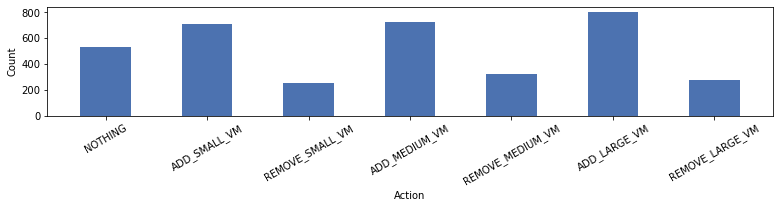

In [48]:
plot_action_histogram(predictions)

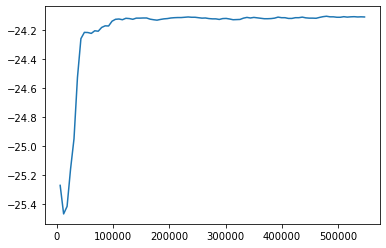

In [14]:
df = parse_tensorboard(path=f'{BASE_PATH}/recurrentppo/MlpLstmPolicy/RecurrentPPO_18', scalars=['rollout/ep_rew_mean'])
plt.plot(df['rollout/ep_rew_mean']['step'], df['rollout/ep_rew_mean']['value'])

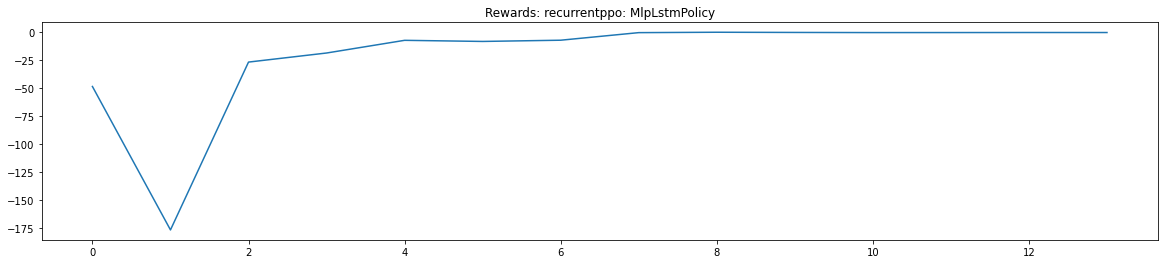

In [80]:
plot_training_data(f'{BASE_PATH}/recurrentppo/MlpLstmPolicy/training_data.csv', data_type='reward', title='recurrentppo: MlpLstmPolicy')

# Attributions

In [42]:
from ppo_policy import RecurrentPPOPolicy, RNNStates
ppo_net = RecurrentPPOPolicy(model.observation_space, model.action_space, model.lr_schedule, model)

In [43]:
ppo_net.lstm_hidden_state_shape

(1, 1, 256)

In [44]:
x = torch.tensor(X[0])
# x = torch.tensor(X)
ppo_net.forward(
    x, 
    lstm_states=RNNStates(
        pi=(torch.zeros(ppo_net.lstm_hidden_state_shape), torch.zeros(ppo_net.lstm_hidden_state_shape)), 
        vf=(torch.zeros(ppo_net.lstm_hidden_state_shape), torch.zeros(ppo_net.lstm_hidden_state_shape))),
    episode_starts=torch.zeros(0))

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[-0.6617]], grad_fn=<AddmmBackward0>)

In [45]:
x = torch.tensor(X[1])
ppo_net.predict(x)[0][0]

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


2

In [30]:
# for w in ppo_net.lstm_actor.all_weights[0]:
#     print(w.shape)

torch.Size([1024, 7])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])


In [ ]:
# plot observations so you can choose which timeframe you want to analise

In [49]:
# Random samples
N = 1000
idxs = np.random.choice(np.arange(X.shape[0]), size=N)
X_sample = X[idxs]
predictions_sample = predictions[idxs]

# Sequential samples
# i_start = 0
# i_stop = 500
# X_sample = X[i_start:i_stop]
# predictions_sample = predictions[i_start:i_stop]

ig_attributor = IGAttributor(net=ppo_net,
                            policy='mlp',
                            agent='ppo',
                            data=X_sample,
                            predictions=predictions_sample,
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

# Mean Attributions

In [50]:

mean_attributions_per_action = ig_attributor.get_mean_attributions()

In [51]:
mean_attributions_per_action = [action_att.sum(0) / np.linalg.norm(action_att.sum(0), ord=1) for action_att in ig_attributor.attributions]

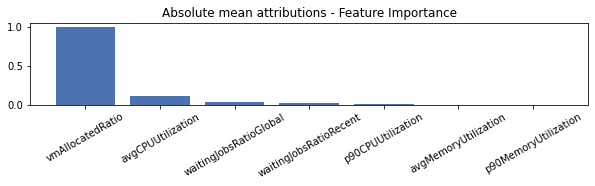

In [52]:
plot_mean_attributions(mean_attributions=mean_attributions_per_action[0], abs=True)

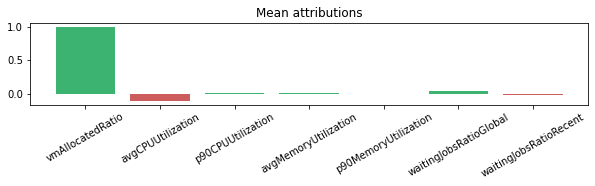

In [53]:
plot_mean_attributions(mean_attributions=mean_attributions_per_action[0])

# Attributions for examples

1


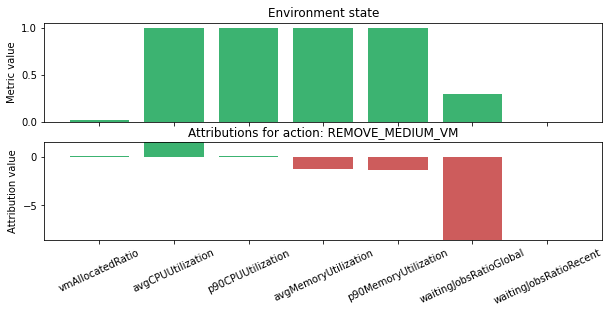

In [34]:
ig_attributor.explain_example(0)

In [26]:
action_observation_map = get_action_observation_map(predictions)

Observation count for each action:
{'ADD_LARGE_VM': 2560,
 'ADD_MEDIUM_VM': 2326,
 'ADD_SMALL_VM': 2316,
 'NOTHING': 1519,
 'REMOVE_LARGE_VM': 950,
 'REMOVE_MEDIUM_VM': 1040,
 'REMOVE_SMALL_VM': 1081}


In [28]:
idx = action_observation_map['REMOVE_LARGE_VM'].squeeze(1)[:300]

In [29]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='mlp',
                            agent='ppo',
                            data=X[idx],
                            predictions=predictions[idx],
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: REMOVE_LARGE_VM


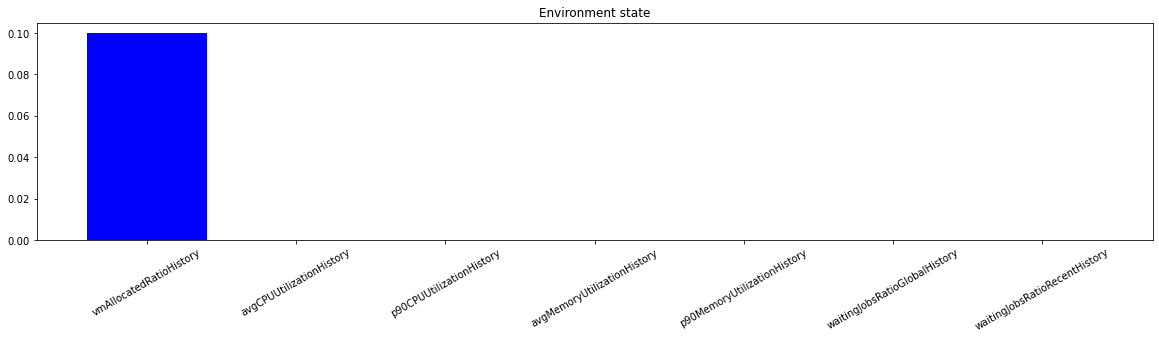

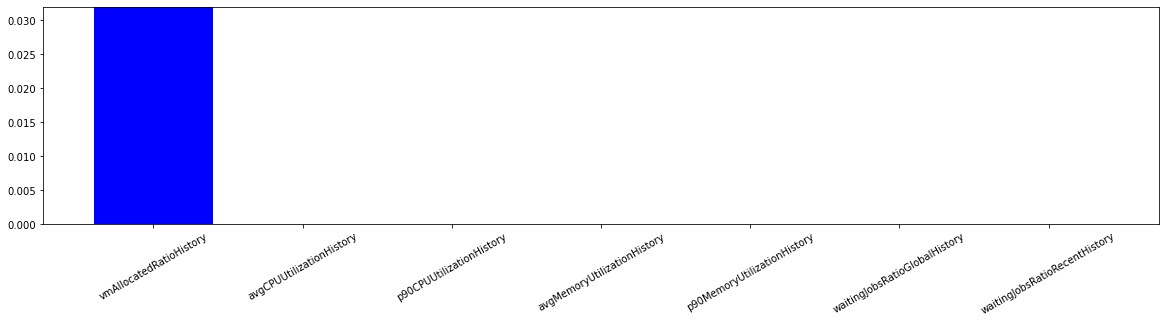

In [30]:
ig_attributor.explain_example(idx=0)

Action made: REMOVE_LARGE_VM


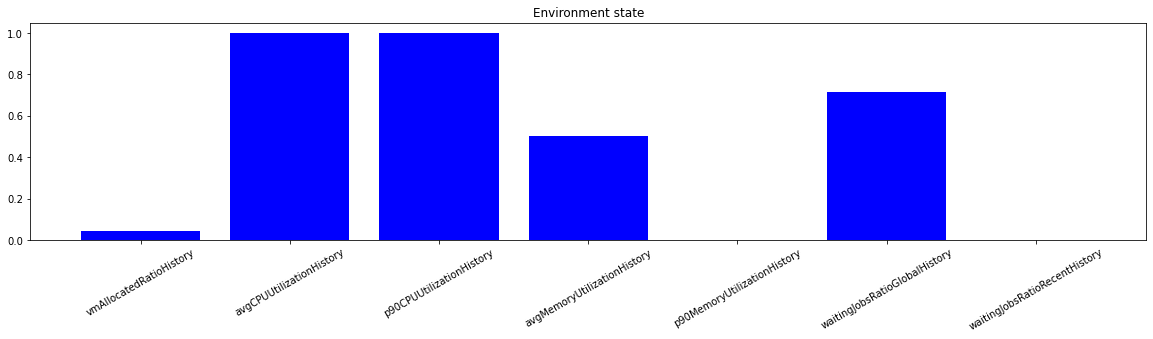

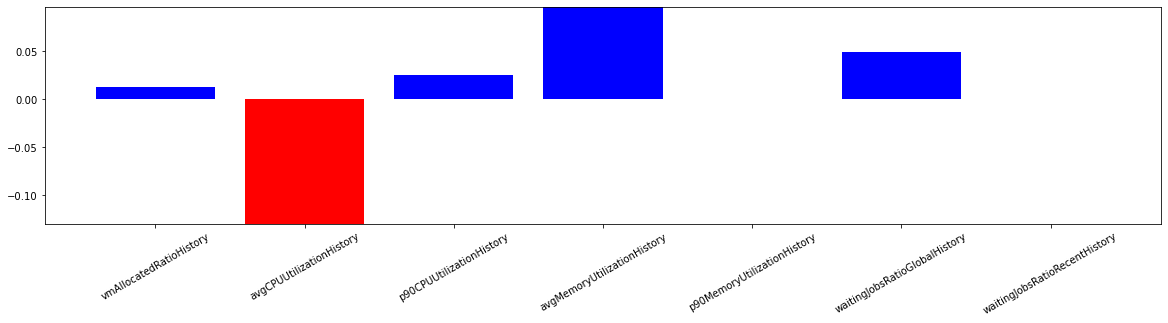

In [32]:
ig_attributor.explain_example(idx=10)

Action made: REMOVE_LARGE_VM


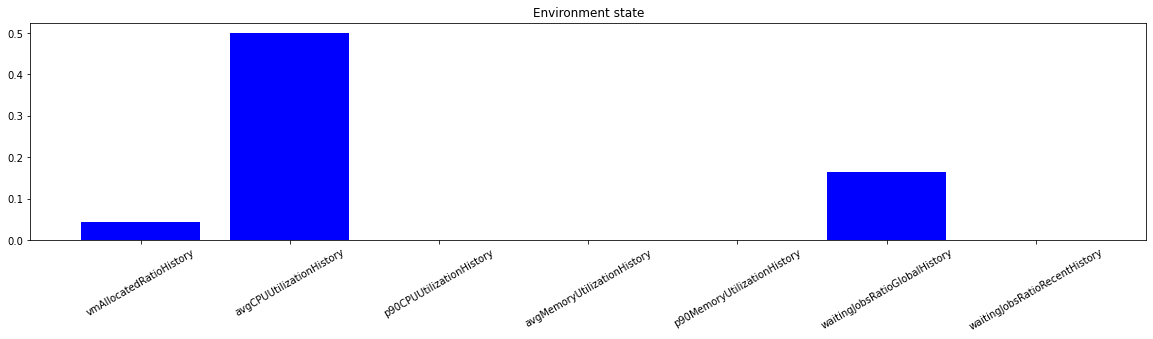

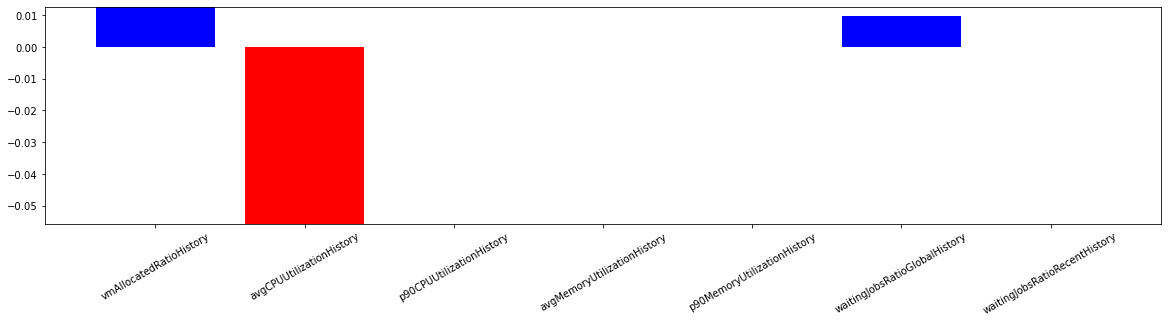

In [35]:
ig_attributor.explain_example(idx=50)

In [19]:
X_manual = torch.Tensor([
    [[0, 1, 1, 1, 1, 1, 1]],
    [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]],
    [[0, 1, 1, 0, 0, 1, 1]],
    [[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]
    ])
predictions_manual = []
for _ in X_manual:
    predictions_manual.append(model.predict(X_manual[0])[0][0])
predictions_manual = np.array(predictions_manual)

In [20]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='mlp',
                            agent='ppo',
                            data=X_manual,
                            predictions=predictions_manual,
                            forward_args=(RNNStates(
                    pi=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256)), 
                    vf=(torch.zeros(1, 1, 256), torch.zeros(1, 1, 256))),
                    torch.zeros(0)))

Action made: NOTHING


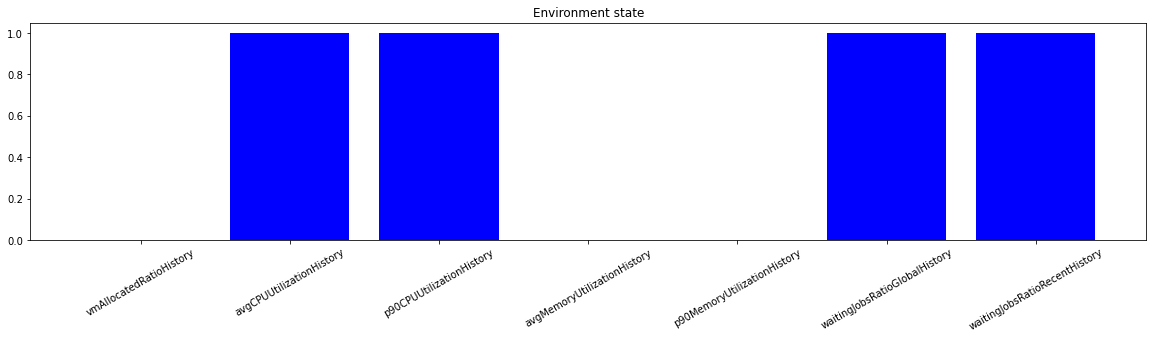

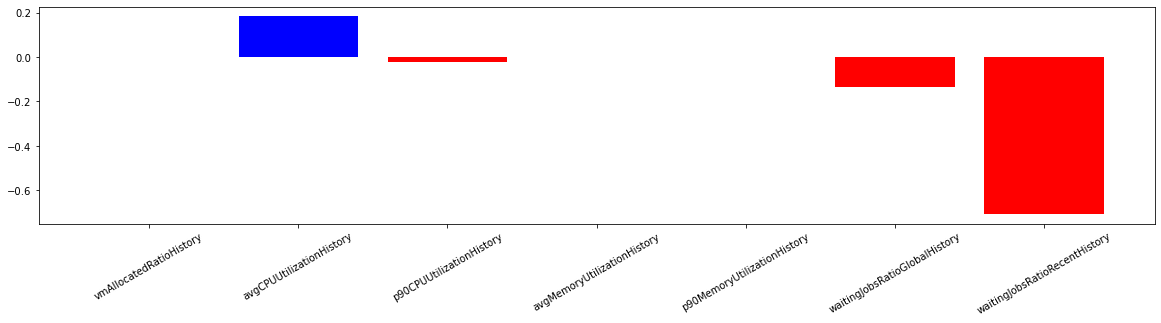

In [21]:
ig_attributor.explain_example(idx=2)

Action made: NOTHING


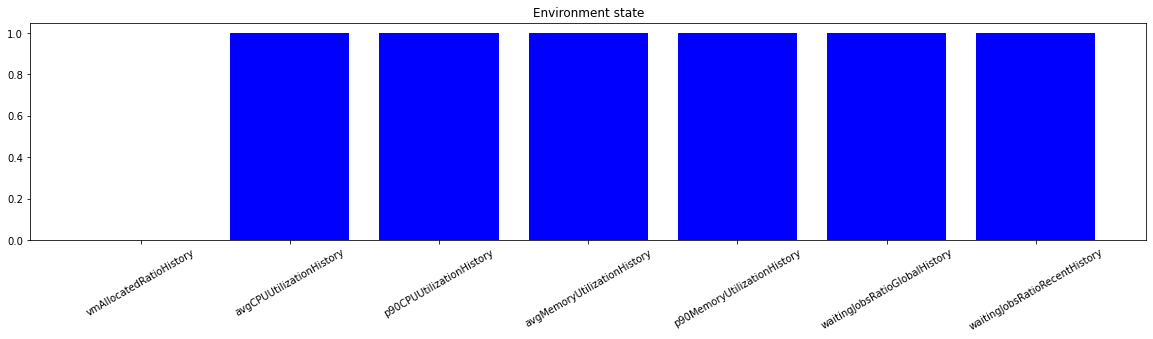

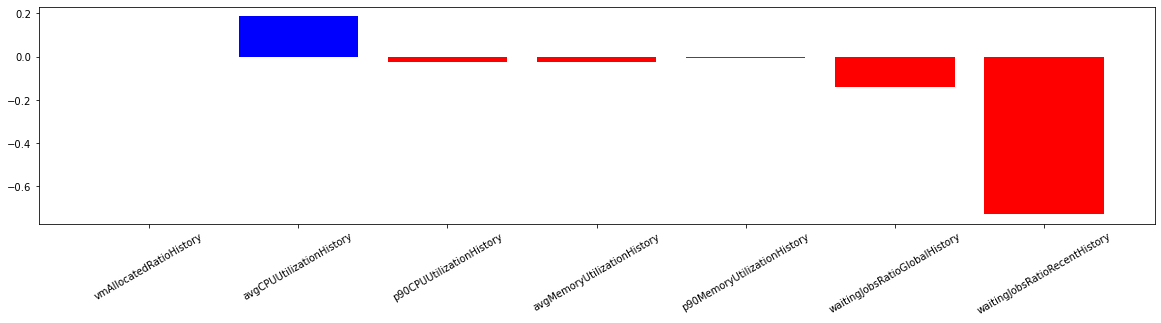

In [22]:
ig_attributor.explain_example(idx=0)